<a href="https://colab.research.google.com/github/dhruthick/cse256project/blob/main/recommendation/xgboost_with-mood-features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost - Final Stage of recommendation with mood-based features

## Imports and setup

In [1]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=879168 sha256=2337b51298190aa3507a1947579210c6ddb02ab596e0d31fe3934a8f78586fb0
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import joblib
import math

import pickle
from tqdm.notebook import tqdm

from lightfm import LightFM
from scipy import stats
import csv
from collections import defaultdict

import xgboost
from sklearn.model_selection import train_test_split

In [4]:
data_path='/content/drive/MyDrive/cse256/project/data/'
models_path='/content/drive/MyDrive/cse256/project/models/'


## Read Data

In [ ]:
all_interactions=pd.read_csv(data_path+'all_interactions.csv').drop('pid',axis=1)
interactions_train=pd.read_csv(data_path+'interactions_train.csv').drop('pid',axis=1)
interactions_val=pd.read_csv(data_path+'interactions_val.csv').drop('pid',axis=1)
cs_model=joblib.load(open(models_path+'lightfm_model.pkl', 'rb'))

In [ ]:
track_tid2uri=defaultdict(str)
for uri, tid in all_interactions.drop_duplicates(['track_uri'])[['track_uri','tid']].values:
  track_tid2uri[tid]=uri

## Fetch saved mood predictions made by our BERT model

In [ ]:
lyric_predictions=pd.read_csv(data_path+'spotify-lyrics-with-predictions.csv')

In [ ]:
track_uri2mood=defaultdict(int)
for uri,mood in lyric_predictions[['uri','mood']].values:
  track_uri2mood[uri]=mood

In [ ]:
del lyric_predictions

## Fetch candidate tracks saved from earlier along with features

In [ ]:
xg_data=pd.read_csv(data_path+'xg_data.csv')

## Add mood-based features

In [ ]:
xg_data['mood']=xg_data.tid.apply(lambda x:track_uri2mood[track_tid2uri[x]])

In [ ]:
common_mood_in_playlist={}
for pid in tracksPerPlaylist:
  common_mood_in_playlist[pid]=stats.mode([track_uri2mood[track_tid2uri[t]] for t in tracksPerPlaylist[pid]]).mode[0]

<ipython-input-23-b29589915875>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  common_mood_in_playlist[pid]=stats.mode([track_uri2mood[track_tid2uri[t]] for t in tracksPerPlaylist[pid]]).mode[0]


In [ ]:
xg_data['playlist_mood']=xg_data.pid.apply(lambda x:common_mood_in_playlist[x])

## Some necessary data structures

In [ ]:
num_playlists=len(np.unique(interactions_train.gen_pid))
num_tracks=len(np.unique(all_interactions.tid))

In [ ]:
playlistsPerTrack = defaultdict(set)
tracksPerPlaylist = defaultdict(set)
trackNames={}
track_id2artist_uri={}
track_id2album_uri={}
artist_count=defaultdict(int)
album_count=defaultdict(int)
for pid,tid,track_name,artist,album_uri,artist_uri in tqdm(interactions_train[['gen_pid','tid','track_name','artist_name','album_uri','artist_uri']].values.tolist()):
    playlistsPerTrack[tid].add(pid)
    tracksPerPlaylist[pid].add(tid)
    trackNames[tid] = (track_name, artist)
    track_id2artist_uri[tid]=artist_uri
    track_id2album_uri[tid]=album_uri
    artist_count[artist_uri]+=1
    album_count[album_uri]+=1

  0%|          | 0/598734 [00:00<?, ?it/s]

In [ ]:
playlists_info={}
for pid, ptracks in interactions_train.groupby('gen_pid'):
    track_ids= ptracks.tid.values.tolist()
    album_uris=ptracks.album_uri.tolist()
    artist_uris=ptracks.artist_uri.tolist()
    playlists_info[pid]={
        'tracks':track_ids,
        'albums':album_uris,
        'artists':artist_uris
    }

## Train XGBoost

In [ ]:
train,test=train_test_split(xg_data,test_size=0.20,stratify=xg_data.target)
train.to_csv(data_path+'xg_data_mood_train.csv',index=False)
test.to_csv(data_path+'xg_data_mood_test.csv',index=False)

In [ ]:
del xg_data

In [ ]:
cols = ['pid', 'tid', 'target']
train=pd.read_csv(data_path+'xg_data_mood_train.csv')
xgtrain = xgboost.DMatrix(train.drop(cols, axis=1), train.target)
del train

In [ ]:
test=pd.read_csv(data_path+'xg_data_mood_test.csv')
xgval = xgboost.DMatrix(test.drop(cols, axis=1), test.target)
del test

In [ ]:
params = {
    'objective':'binary:logistic',
    'eta':0.1,
    'booster':'gbtree',
    'max_depth':7,
    'nthread':50,
    'seed':1,
    'eval_metric':'auc',
}

a = xgboost.train(
    params=list(params.items()),
    early_stopping_rounds=30,
    verbose_eval=10,
    dtrain=xgtrain,
    evals=[(xgtrain, 'train'), (xgval, 'test')],
    num_boost_round=300,
)

[0]	train-auc:0.85794	test-auc:0.85600
[10]	train-auc:0.86866	test-auc:0.86746
[20]	train-auc:0.87060	test-auc:0.86937
[30]	train-auc:0.87688	test-auc:0.87538
[40]	train-auc:0.87929	test-auc:0.87730
[50]	train-auc:0.88152	test-auc:0.87890
[60]	train-auc:0.88386	test-auc:0.88066
[70]	train-auc:0.88569	test-auc:0.88180
[80]	train-auc:0.88714	test-auc:0.88267
[90]	train-auc:0.88831	test-auc:0.88324
[100]	train-auc:0.88919	test-auc:0.88360
[110]	train-auc:0.88987	test-auc:0.88380
[120]	train-auc:0.89054	test-auc:0.88400
[130]	train-auc:0.89113	test-auc:0.88410
[140]	train-auc:0.89164	test-auc:0.88418
[150]	train-auc:0.89204	test-auc:0.88426
[160]	train-auc:0.89255	test-auc:0.88432
[170]	train-auc:0.89294	test-auc:0.88438
[180]	train-auc:0.89324	test-auc:0.88438
[190]	train-auc:0.89377	test-auc:0.88438
[200]	train-auc:0.89415	test-auc:0.88435


In [ ]:
pickle.dump(a, open(models_path+'xgboost_mood_2f.pkl', "wb"))

In [5]:
a = pickle.load(open(models_path+'xgboost_mood_2f.pkl', "rb"))

## Functions for recommendation evaluation

In [ ]:
def get_scores(pid,N):
  all_tracks=np.unique(all_interactions.tid)
  ptracks=tracksPerPlaylist[pid]
  pred_tracks=[t for t in all_tracks if t not in ptracks]
  scores=cs_model.predict(user_ids=[pid for i in range(len(pred_tracks))],
                item_ids=pred_tracks)
  scores=[(scores[i],pred_tracks[i]) for i in range(len(pred_tracks))]
  scores.sort(reverse=True)
  return scores[:N]


In [ ]:
def evaluate_playlist(pid,scores,N):
  relevantTracks=set(interactions_test[interactions_test['gen_pid']==pid].tid.values)
  scores=scores[:N]
  recommendedTracks=set([t[1] for t in scores])
  rprc=len(recommendedTracks.intersection(relevantTracks))/len(relevantTracks)
  dcg=0
  for i in range(len(scores)):
    if scores[i][1] in relevantTracks:
      dcg+=math.log(2)/math.log(i+2)
  ndcg=dcg/len(relevantTracks)
  rec_click=int(N/10)+1
  for i in range(0,int(N/10)):
    recommendedTracks=set([t[1] for t in scores[i*10:(i*10+10)]])
    if len(recommendedTracks.intersection(relevantTracks))>0:
      rec_click=i+1
      break
  return rprc,ndcg,rec_click

## XGBoost Evaluation

In [ ]:
interactions_test=pd.read_csv(data_path+'interactions_test.csv')

In [ ]:
cols=['score','rank','track_bias','playlist_bias','dot_product','max_coo','min_coo','mean_coo','median_coc',
         'max_ncoo','min_ncoo','mean_ncoo','median_coo','track_artist_count','track_album_count',
         'track_artist_share','track_album_share','global_track_count','global_artist_count','global_album_count',
         'unique_album_count','unique_artist_count','num_tracks_in_playlist','mood']

In [ ]:
track_biases, track_embeddings = cs_model.get_item_representations()
playlist_biases, playlist_embeddings = cs_model.get_user_representations()

rprcs,ndcgs,rec_clicks=[],[],[]

for pid in tqdm(np.unique(interactions_test.gen_pid)):
  candidates=[]
  candidate_stats=[]
  candidate_tracks=get_scores(pid,750)
  tracks_in_playlist=tracksPerPlaylist[pid]
  # relevant_tracks=set(interactions_val[interactions_val['gen_pid']==pid].tid.values)
  playlist_features=[len(np.unique(playlists_info[pid]['albums'])),
                     len(np.unique(playlists_info[pid]['artists'])),len(tracks_in_playlist)]
  for i in range(len(candidate_tracks)):
    score,tid=candidate_tracks[i]
    candidates.append(tid)
    sample=[score,i,track_biases[tid],playlist_biases[pid],
            track_embeddings[tid].dot(playlist_embeddings[pid])]
    playlists_with_ctrack=playlistsPerTrack[tid]
    co_occurence=[]
    norm_co_occurence=[]
    for playlist_track in tracks_in_playlist:
      other_playlists=playlistsPerTrack[playlist_track]
      n=len(other_playlists.intersection(playlists_with_ctrack))
      co_occurence.append(n)
      norm_co_occurence.append(n/len(other_playlists))
    sample.extend([max(co_occurence),min(co_occurence),np.mean(co_occurence),np.median(co_occurence)])
    sample.extend([max(norm_co_occurence),min(norm_co_occurence),np.mean(norm_co_occurence),np.median(norm_co_occurence)])
    t_artist_count=playlists_info[pid]['artists'].count(track_id2artist_uri[tid])
    t_album_count=playlists_info[pid]['albums'].count(track_id2album_uri[tid])
    sample.extend([t_artist_count,t_album_count,
                   t_artist_count/len(tracks_in_playlist),
                   t_album_count/len(tracks_in_playlist)])
    sample.extend([len(playlists_with_ctrack),
                   artist_count[track_id2artist_uri[tid]],
                   album_count[track_id2album_uri[tid]]])
    sample.extend(playlist_features)
    sample.append(track_uri2mood[track_tid2uri[tid]])
    # sample.append(1 if tid in relevant_tracks else 0)
    candidate_stats.append(sample)
  xgtest=xgboost.DMatrix(pd.DataFrame(candidate_stats, columns=cols))
  pred_scores=a.predict(xgtest)
  pred_scores=[(pred_scores[i],candidates[i]) for i in range(len(candidates))]
  pred_scores.sort(reverse=True)
  rprc,ndcg,rec_click=evaluate_playlist(pid,pred_scores,500)
  rprcs.append(rprc)
  ndcgs.append(ndcg)
  rec_clicks.append(rec_click)

print(f'\nAverage R-Precision: {np.average(rprcs)}')
print(f'Average NDCG: {np.average(ndcgs)}')
print(f'Average Recommendation Clicks: {np.average(rec_clicks)}')

  0%|          | 0/17500 [00:00<?, ?it/s]


Average R-Precision: 0.5667470700772212
Average NDCG: 0.1376010433748868
Average Recommendation Clicks: 7.348685714285715


## Feature Importance

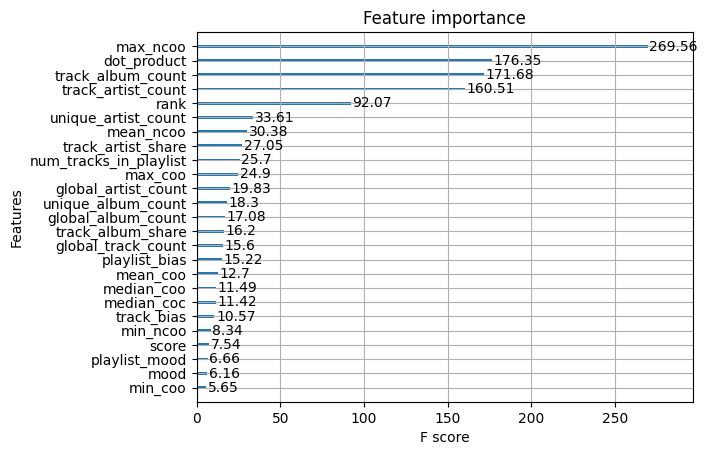

In [7]:
importance = a.get_score(importance_type="gain")

for key in importance.keys():
    importance[key] = round(importance[key],2)

ax = xgboost.plot_importance(importance, importance_type='gain', show_values=True,)